# **Importing Libaries & Data Tables**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
target_path = "../data/raw/shavedice-dataset/hourly_normalized.parquet"

df = pd.read_parquet(target_path)
print("--- FIRST 5 ROWS ---")
display(df.head())
print("\n--- DATA INFO ---")
df.info()
print("\n--- COLUMN NAMES ---")
print(df.columns.tolist())

--- FIRST 5 ROWS ---


,USAGE_HOUR,REGION_NUM,INSTANCE_TYPE,NORM_USAGE
0,2021-02-01 00:00:00+00:00,2,A,172.0
1,2021-02-01 00:00:00+00:00,4,F,1.0
2,2021-02-01 00:00:00+00:00,1,I,9.0
3,2021-02-01 00:00:00+00:00,4,I,8.0
4,2021-02-01 00:00:00+00:00,3,I,6.0



--- DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524832 entries, 0 to 524831
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   USAGE_HOUR     524832 non-null  datetime64[ms, UTC]
 1   REGION_NUM     524832 non-null  object             
 2   INSTANCE_TYPE  524832 non-null  object             
 3   NORM_USAGE     524832 non-null  float64            
dtypes: datetime64[ms, UTC](1), float64(1), object(2)
memory usage: 16.0+ MB

--- COLUMN NAMES ---
['USAGE_HOUR', 'REGION_NUM', 'INSTANCE_TYPE', 'NORM_USAGE']


In [4]:
filepath = "../src"

try:
    os.chdir(filepath)
    print(f"✅ Success! Working Directory is now: {os.getcwd()}")
except FileNotFoundError:
    print(f"❌ Error: Could not find path: {filepath}")
    
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

from duckdb_loader import load_mart_data, list_tables, run_query

✅ Success! Working Directory is now: /mnt/d/Git_Respository/Python/Projects/Snowflake Shaved Ice 2026/Shaved Ice/src


In [4]:
query = ['SELECT * FROM ' + x  for x in list_tables()] 
tables = [run_query(query[i]) for i in range(len(list_tables()))]

In [5]:
# List existing tables and their respective attributes
print(list_tables(), "\n")
for i in tables:
    print(i.columns)

['int_daily_demand', 'mart_forecast_input', 'mart_stockout_events', 'stg_shaved_ice'] 

Index(['date', 'region', 'instance_type', 'daily_demand_total',
       'daily_demand_avg', 'daily_demand_max', 'daily_demand_min',
       'hourly_records', 'daily_demand_stddev', 'year', 'month', 'day_of_week',
       'week_of_year', 'is_weekend', 'demand_lag_1d', 'demand_lag_7d',
       'demand_rolling_7d_avg'],
      dtype='object')
Index(['date', 'region', 'instance_type', 'year', 'month', 'day_of_week',
       'week_of_year', 'is_weekend', 'demand', 'daily_demand_avg',
       'daily_demand_max', 'daily_demand_min', 'daily_demand_stddev',
       'demand_lag_1d', 'demand_lag_7d', 'demand_rolling_7d_avg',
       'safety_stock_90pct', 'safety_stock_95pct', 'safety_stock_99pct',
       'hourly_records', 'complete_day_flag'],
      dtype='object')
Index(['date', 'region', 'instance_type', 'demand', 'daily_demand_max',
       'capacity_limit_p95', 'severity_pct'],
      dtype='object')
Index(['timestam

# **Part 1: Exploratory Data Analysis**
**Data Source:** `stg_shaved_ice` (Cleaned Hourly Data)

## **1.1 Load Duration Curve**
* **Goal:** The Load Duration Curve (LDC) allows us to determine the optimal capacity commitment required to cover 95% of total operational time (P95). A year-over-year comparison reveals a structural upward drift in usage, which we quantify using the Median demand to avoid skew from transient volatility. Leveraging the historical growth velocity observed between 2023 and 2024, we projected future demand for 2025 and 2026, incorporating a conservative decay factor to account for the natural saturation of growth rates.
* **Key Insight:** Demonstrates why 100% commitment is mathematically inefficient due to the steep tail of the curve.

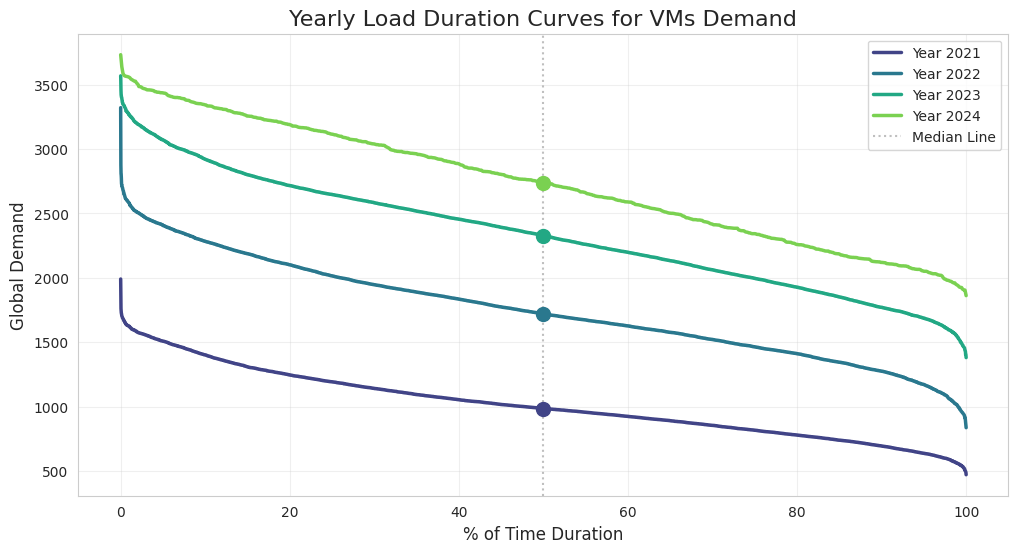

In [6]:

df = tables[3].copy()

df['timestamp'] = pd.to_datetime(df['timestamp'])
global_demand = df.groupby('timestamp')['demand'].sum().reset_index()
global_demand['year'] = global_demand['timestamp'].dt.year

plt.figure(figsize=(12, 6))
years = sorted(global_demand['year'].unique())
colors = sns.color_palette("viridis", len(years))

for i, year in enumerate(years):
    year_data = global_demand[global_demand['year'] == year]
    y_values = year_data['demand'].sort_values(ascending=False).values
    x_values = np.linspace(0, 100, len(y_values))
    plt.plot(x_values, y_values, label=f'Year {year}', color=colors[i], linewidth=2.5)
    median = np.median(y_values)
    plt.scatter(50, median, color=colors[i], s=100, zorder=5)

plt.title('Yearly Load Duration Curves for VMs Demand', fontsize=16)
plt.ylabel('Global Demand', fontsize=12)
plt.xlabel('% of Time Duration', fontsize=12)
plt.axvline(50, color='gray', linestyle=':', alpha=0.5, label='Median Line')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **1.2 Operational Heat Map**
* **Goal:** Map demand intensity across `Day of Week` vs. `Hour of Day`.
* **Key Insight:** Based on the heatmap the operational profile displays a 1.8x volatility ratio where demand fluctuates between a stable base load of roughly 1900 credits during nights and weekends and an intense peak of approximately 3400 units specifically on Tuesday through Friday mornings. The data reveals a front loaded work week with the maximum cost pressure concentrated heavily between 8 AM and 3 PM on weekdays. This explicitly confirms that a static 100% Reserved Instance commitment would be financially inefficient as it would result in roughly 45% unused capacity during the deep blue off peak windows. The optimal strategy is to reserve the 1900 credit baseline and utilize On Demand Instances for the volatile midday spikes.

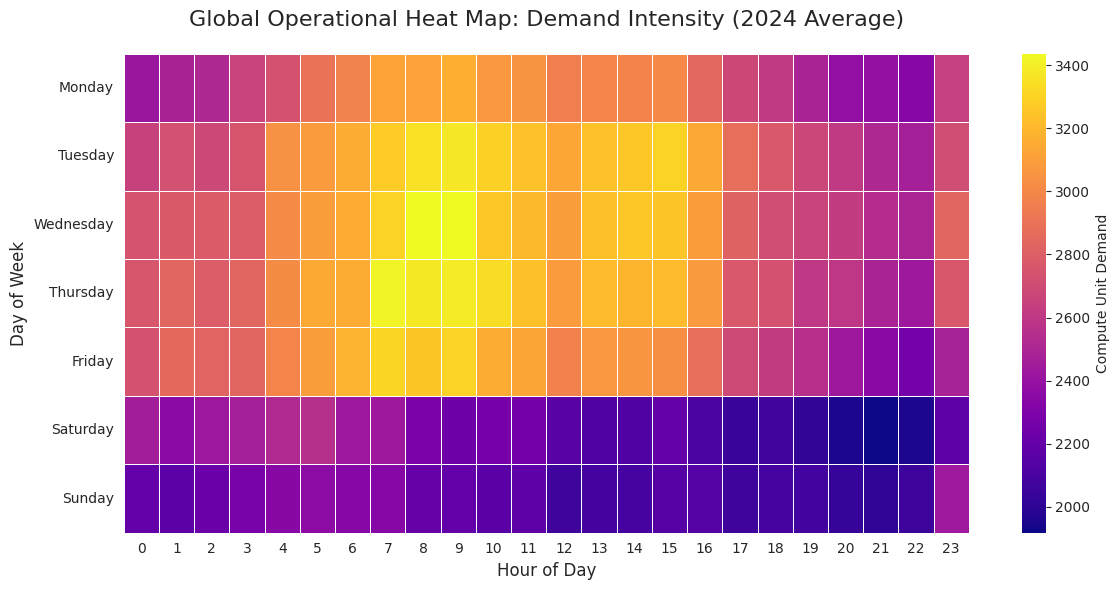

Heatmap Peak Value: 1,918
Heatmap Peak Value: 3,436


In [7]:
df_hourly = tables[3].copy() # stg_shaved_ice
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])
global_hourly = df_hourly.groupby('timestamp')['demand'].sum().reset_index()


global_hourly['day_name'] = global_hourly['timestamp'].dt.day_name()
global_hourly['hour'] = global_hourly['timestamp'].dt.hour
global_hourly['year'] = global_hourly['timestamp'].dt.year


heatmap_source = global_hourly[global_hourly['year'] == 2024]
heatmap_pattern = heatmap_source.groupby(['day_name', 'hour'])['demand'].mean().reset_index()

heatmap_data = heatmap_pattern.pivot(index='day_name', columns='hour', values='demand')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, 
            cmap='plasma', 
            linewidths=0.5, 
            linecolor='white', 
            annot=False, 
            cbar_kws={'label': 'Compute Unit Demand'})

plt.title('Global Operational Heat Map: Demand Intensity (2024 Average)', fontsize=16, pad=20)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Heatmap Peak Value: {heatmap_pattern['demand'].min():,.0f}")
print(f"Heatmap Peak Value: {heatmap_pattern['demand'].max():,.0f}")

# **Part 2: Forecasting & Optimization**
**Data Source:** `mart_forecast_input` (Cleaned Daily Avg Data)

## 2.1 **Naive Forecast Model**

We project future demand using a compound growth model with annual deceleration to reflect system maturation. The growth rate derived from daily medians is applied uniformly to scale the entire hourly demand curve, preserving its intra-day shape while adjusting for annual trend.

### **Forecast Equation**

$$\hat{Y}_{T+h} = Y_T \times \prod_{i=1}^{h} (1 + r_i)$$

### **Symbols**

- $\hat{Y}_{T+h}$: The forecasted hourly demand curve for year $T+h$ (e.g., 2026)
- $Y_T$: The baseline hourly demand curve from the last observed year (e.g., 2024) — 8,760 observations
- $\prod$: The product operator (implies multiplication of the sequence)
- $r_i$: The projected growth rate for year $i$
- $h$: The number of years into the future

### **Calculation of Growth Rates ($r_i$)**

**1. Historical Drift (Initial Rate)**

The base growth rate is calculated using the relative change in the median daily demand between the two most recent observed years:

$$r_{initial} = \frac{M_{t} - M_{t-1}}{M_{t-1}}$$

Where:
- $M_t$: The median daily usage in the most recent actual year (e.g., 2024)
- $M_{t-1}$: The median daily usage of the previous year (e.g., 2023)

**2. Dampened Future Drift (Projected Rates)**

To account for the natural deceleration of growth as the system matures, we apply a decay factor ($\lambda$) to the initial rate for each subsequent year $h$ into the future:

$$r_{h} = r_{initial} \times \lambda^{h-1}$$

Where:
- $\lambda$: The Decay Factor (e.g., $0.90$ implies growth slows by 10% each year)
- $h$: The forecast year (where $h=1$ is 2025, $h=2$ is 2026, etc.)

### **Growth Velocity**

- **Historical Drift:** Median growth reached **33.3%** between 2023 and 2024
- **2025 Projection:** Growth is projected to settle at **30.0%** after applying the initial decay factor ($r_{initial} \times 0.90^1$)
- **2026 Projection:** Growth is expected to further decelerate to **27.0%** as the system matures ($r_{initial} \times 0.90^2$)

### **Demand Profile**

- **Hourly Range:** 2024 actuals demonstrate a global hourly demand floor of **1,862 credits** and a ceiling of **3,732 credits**
- **Operational Intensity:** Heatmap data confirms peak utilization occurs midday from Monday through Friday, with significant tapering on weekends



## 2.2 Reserved Capacity Optimization

Given the forecasted demand curve $D_t$, we determine the optimal reserved capacity $K^*$ by minimizing total annual cost. The optimization balances fixed commitment costs against variable on-demand overage expenses.

### Cost Function

$$TC(K) = \underbrace{K \cdot T \cdot P_{commit}}_{\text{Fixed Cost}} + \underbrace{\sum_{t=1}^{T} \max(0, D_t - K) \cdot P_{on\_demand}}_{\text{Variable Overage Cost}}$$

### Where:

- $TC(K)$: The Total Cost function we are minimizing
- $K$: The Commit Capacity (Decision Variable)
- $T$: Total hours in the forecast period ($8,760$ for non-leap years)
- $P_{commit}$: The discounted Committed (Reserved) Rate
- $D_t$: The Projected Demand at hour $t$
- $P_{on\_demand}$: The On-Demand (Overage) Rate
- $\max(0, D_t - K)$: The Spillover function (calculates overage only when demand exceeds commit)

### Configuration

**Source:** Vantage AWS EC2 Comparison - r5.2xlarge | US West Oregon

- **Instance Specs:** 8 vCPUs, 64 GiB RAM, 109k CoreMark
- **Real On-Demand Rate:** \$0.504/hour
- **Real 1-yr No Upfront Reserved Rate:** \$0.318/hour
- **Annual Growth Decay Rate:** 0.90

### Goal

The capacity planning model identifies a highly stable infrastructure profile with consistent year-over-year growth. The analysis confirms that workloads are heavily concentrated on weekdays with significant tapering occurring on weekends.

### Optimization Results

| Year | Optimal Commit (credits/hr) | Reserved Cost | On-Demand Cost | Total Cost | vs 100% On-Demand | Savings | Coverage |
|------|----------------------------|---------------|----------------|------------|-------------------|---------|----------|
| **2025** | 3,305 | \$781,842 | \$146,281 | \$928,123 | \$1,331,548 | **30.3%** (\$403,425) | 62.6% of hours |
| **2026** | 4,197 | \$992,939 | \$185,776 | \$1,178,716 | \$1,691,066 | **30.3%** (\$512,350) | 62.6% of hours |

**Key Findings:**

- **2025 Target:** The optimal commitment is **3,305 credits/hour**, covering the majority of the forecasted load while minimizing on-demand spillover
- **2026 Target:** To maintain cost-efficiency against projected growth, the commitment should increase to **4,197 credits/hour**
- **Cost Efficiency:** The optimization achieves consistent **30.3% savings** compared to 100% on-demand provisioning
- **Commitment Coverage:** The reserved capacity covers approximately **62.5% of operational hours**, representing an optimal balance between fixed and variable costs

Growth (Median-Based):   33.3%
Forecast Rate 2025:      30.0%
Forecast Rate 2026:      27.0%
Global Min:    1,862
Global Median: 2,740
Global Max:    3,732


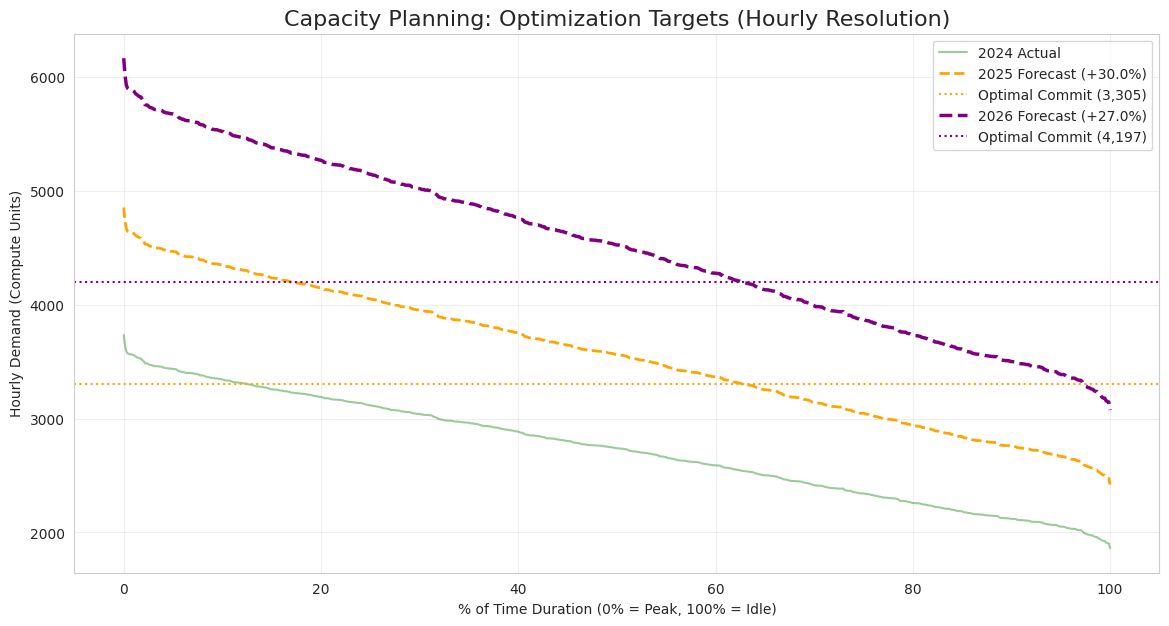

------------------------------
OPTIMAL 2025 COMMIT: 3,305 Credits/Hour
OPTIMAL 2026 COMMIT: 4,197 Credits/Hour
------------------------------


In [8]:
# --- 1. CONFIGURATION (r5.2xlarge | US West Oregon) ---
# Source: Vantage AWS EC2 Comparison - 8 vCPUs, 64 GiB RAM, 109k CoreMark
AWS_OD_RATE = 0.504    # Real On-Demand Rate
AWS_RI_RATE = 0.318    # Real 1-yr No Upfront Reserved Rate
DECAY_FACTOR = 0.90    # 10% annual growth deceleration

# --- 2. FORECASTING (Using Median Trend from Daily Data) ---
mart_df = tables[1].copy() # mart_forecast_input

median_2023 = mart_df[mart_df['year'] == 2023]['demand'].median()
median_2024 = mart_df[mart_df['year'] == 2024]['demand'].median()

# Calculate Historical Drift
if median_2023 > 0:
    historical_growth = (median_2024 - median_2023) / median_2023
else:
    historical_growth = 0.333 # Fallback based on analysis results

# Apply Dampened Future Drift
rate_2025 = historical_growth * DECAY_FACTOR
rate_2026 = rate_2025 * DECAY_FACTOR

print(f"Growth (Median-Based):   {historical_growth:.1%}")
print(f"Forecast Rate 2025:      {rate_2025:.1%}")
print(f"Forecast Rate 2026:      {rate_2026:.1%}")

# --- 3. OPTIMIZATION ---
hourly_df = tables[3].copy() # stg_shaved_ice
# Aggregate to Global Hourly Load (Company-wide)
global_hourly_df = hourly_df.groupby('timestamp')['demand'].sum().reset_index()
base_hourly_curve = global_hourly_df[global_hourly_df['timestamp'].dt.year == 2024]['demand'].values

print(f"Global Min:    {base_hourly_curve.min():,.0f}")
print(f"Global Median: {np.median(base_hourly_curve):,.0f}")
print(f"Global Max:    {base_hourly_curve.max():,.0f}")

demand_2025 = base_hourly_curve * (1 + rate_2025)
demand_2026 = demand_2025 * (1 + rate_2026)

def get_optimal_commit(demand_curve):
    costs = []
    # Test 100 possible commitment levels (K) using Newsvendor Logic
    commit_options = np.linspace(demand_curve.min(), demand_curve.max(), 100)
    num_hours = len(demand_curve)
    
    for K in commit_options:
        # TC(K) = (Fixed Cost) + (Variable Overage Cost)
        fixed_cost = K * num_hours * AWS_RI_RATE
        overage = np.maximum(0, demand_curve - K) # Spillover function
        variable_cost = np.sum(overage) * AWS_OD_RATE
        
        costs.append(fixed_cost + variable_cost)
    
    return commit_options[np.argmin(costs)]

optimal_commit_2025 = get_optimal_commit(demand_2025)
optimal_commit_2026 = get_optimal_commit(demand_2026)

# --- 4. VISUALIZATION (Load Duration Curve) ---
plt.figure(figsize=(14, 7))

y_2024 = np.sort(base_hourly_curve)[::-1]
x_axis = np.linspace(0, 100, len(y_2024))

plt.plot(x_axis, y_2024, label='2024 Actual', color='green', alpha=0.4)

y_2025 = np.sort(demand_2025)[::-1]
plt.plot(x_axis, y_2025, label=f'2025 Forecast (+{rate_2025:.1%})', color='orange', linewidth=2, linestyle='--')
plt.axhline(optimal_commit_2025, color='orange', linestyle=':', label=f'Optimal Commit ({optimal_commit_2025:,.0f})')

y_2026 = np.sort(demand_2026)[::-1]
plt.plot(x_axis, y_2026, label=f'2026 Forecast (+{rate_2026:.1%})', color='purple', linewidth=2.5, linestyle='--')
plt.axhline(optimal_commit_2026, color='purple', linestyle=':', label=f'Optimal Commit ({optimal_commit_2026:,.0f})')

plt.title('Capacity Planning: Optimization Targets (Hourly Resolution)', fontsize=16)
plt.ylabel('Hourly Demand (Compute Units)')
plt.xlabel('% of Time Duration (0% = Peak, 100% = Idle)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("-" * 30)
print(f"OPTIMAL 2025 COMMIT: {optimal_commit_2025:,.0f} Credits/Hour")
print(f"OPTIMAL 2026 COMMIT: {optimal_commit_2026:,.0f} Credits/Hour")
print("-" * 30)

In [15]:
def print_cost_breakdown(commit, demand_curve, year):
    num_hours = len(demand_curve)
    fixed = commit * num_hours * AWS_RI_RATE
    overage = np.maximum(0, demand_curve - commit)
    variable = np.sum(overage) * AWS_OD_RATE
    total = fixed + variable
    
    # What if we did 100% on-demand?
    all_od = np.sum(demand_curve) * AWS_OD_RATE
    savings = all_od - total
    
    print(f"\n{year} Optimization:")
    print(f"  Optimal Commit:    {commit:,.0f} units/hr")
    print(f"  Reserved Cost:     ${fixed:,.0f}")
    print(f"  On-Demand Cost:    ${variable:,.0f}")
    print(f"  Total Cost:        ${total:,.0f}")
    print(f"  vs 100% On-Demand: ${all_od:,.0f} (save ${savings:,.0f}, {savings/all_od:.1%})")


pct_2025 = np.sum(demand_2025 >= optimal_commit_2025) / len(demand_2025)
pct_2026 = np.sum(demand_2026 >= optimal_commit_2026) / len(demand_2026)

print_cost_breakdown(optimal_commit_2025, demand_2025, "2025")
print(f"  → Commit covers {pct_2025:.1%} of hours\n")

print_cost_breakdown(optimal_commit_2026, demand_2026, "2026")
print(f"  → Commit covers {pct_2026:.1%} of hours")


2025 Optimization:
  Optimal Commit:    3,305 units/hr
  Reserved Cost:     $781,842
  On-Demand Cost:    $146,281
  Total Cost:        $928,123
  vs 100% On-Demand: $1,331,548 (save $403,425, 30.3%)
  → Commit covers 62.6% of hours


2026 Optimization:
  Optimal Commit:    4,197 units/hr
  Reserved Cost:     $992,939
  On-Demand Cost:    $185,776
  Total Cost:        $1,178,716
  vs 100% On-Demand: $1,691,066 (save $512,350, 30.3%)
  → Commit covers 62.6% of hours
